만든 dataset 길이 편향 분석

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer # 토큰 수 계산을 위해 추가

/nfs/home/ryan0507/anaconda3/envs/llama/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# LLM이 인식하는 가장 정확한 길이인 '토큰' 수를 계산하기 위한 토크나이저 로드
# 이전에 사용하셨던 모델의 토크나이저를 사용하는 것이 좋습니다.
tokenizer = AutoTokenizer.from_pretrained("unsloth/llama-3.2-1b-instruct-bnb-4bit")

# 분석할 데이터셋 파일 경로
# 제공해주신 데이터는 한 줄에 하나의 JSON 객체가 있는 'JSON Lines' (.jsonl) 형식일 가능성이 높습니다.
dpo_dataset = 'dpo_preference_dataset.jsonl'
dpo_dataset_mitigated = 'dpo_preference_dataset_mitigated.jsonl'

In [14]:
# ====================================================================
# 1. 데이터 로드 및 길이 계산
# ====================================================================

def extract_assistant_response(full_text):
    """'Assistant:' 이후의 텍스트만 추출하는 함수"""
    parts = full_text.split("Assistant:")
    if len(parts) > 1:
        return parts[1].strip()
    return ""

data_list = []
data_list_mitigated = []
with open(dpo_dataset, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            data = json.loads(line)
            
            chosen_response = extract_assistant_response(data['chosen'])
            rejected_response = extract_assistant_response(data['rejected'])
            
            data_list.append({
                'chosen_len_chars': len(chosen_response),
                'rejected_len_chars': len(rejected_response),
                'chosen_len_words': len(chosen_response.split()),
                'rejected_len_words': len(rejected_response.split()),
                'chosen_len_tokens': len(tokenizer.encode(chosen_response)),
                'rejected_len_tokens': len(tokenizer.encode(rejected_response)),
            })
        except json.JSONDecodeError:
            print(f"JSON 디코딩 오류 발생: {line.strip()}")
            continue
with open(dpo_dataset_mitigated, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            data = json.loads(line)
            
            chosen_response = extract_assistant_response(data['chosen'])
            rejected_response = extract_assistant_response(data['rejected'])
            
            data_list_mitigated.append({
                'chosen_len_chars': len(chosen_response),
                'rejected_len_chars': len(rejected_response),
                'chosen_len_words': len(chosen_response.split()),
                'rejected_len_words': len(rejected_response.split()),
                'chosen_len_tokens': len(tokenizer.encode(chosen_response)),
                'rejected_len_tokens': len(tokenizer.encode(rejected_response)),
            })
        except json.JSONDecodeError:
            print(f"JSON 디코딩 오류 발생: {line.strip()}")
            continue

df = pd.DataFrame(data_list)
df2 = pd.DataFrame(data_list_mitigated)

# 분석을 위해 길이 차이 컬럼 추가
df['token_diff'] = df['chosen_len_tokens'] - df['rejected_len_tokens']
df2['token_diff'] = df2['chosen_len_tokens'] - df2['rejected_len_tokens']

In [6]:
# ====================================================================
# 2. 통계적 분석 결과 출력
# ====================================================================
print("\n" + "="*40)
print("     데이터셋 길이 편향 통계 분석")
print("="*40)

# 평균 길이 비교
avg_chosen_tokens = df['chosen_len_tokens'].mean()
avg_rejected_tokens = df['rejected_len_tokens'].mean()
print(f"평균 토큰 길이:")
print(f"  - Chosen: {avg_chosen_tokens:.2f} tokens")
print(f"  - Rejected: {avg_rejected_tokens:.2f} tokens")
print("-" * 20)

# Chosen이 더 긴 경우의 비율
chosen_is_longer = (df['chosen_len_tokens'] > df['rejected_len_tokens']).sum()
rejected_is_longer = (df['chosen_len_tokens'] < df['rejected_len_tokens']).sum()
equal_length = (df['chosen_len_tokens'] == df['rejected_len_tokens']).sum()
total = len(df)

print("길이 비교 비율:")
print(f"  - Chosen > Rejected: {chosen_is_longer}건 ({chosen_is_longer/total:.2%})")
print(f"  - Rejected > Chosen: {rejected_is_longer}건 ({rejected_is_longer/total:.2%})")
print(f"  - Chosen == Rejected: {equal_length}건 ({equal_length/total:.2%})")
print("="*40)


     데이터셋 길이 편향 통계 분석
평균 토큰 길이:
  - Chosen: 63.27 tokens
  - Rejected: 48.34 tokens
--------------------
길이 비교 비율:
  - Chosen > Rejected: 140건 (71.43%)
  - Rejected > Chosen: 44건 (22.45%)
  - Chosen == Rejected: 12건 (6.12%)


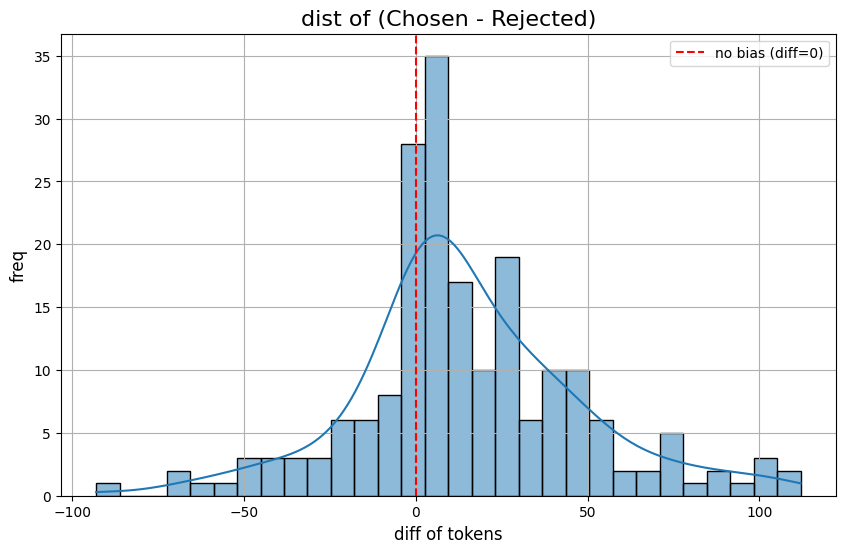

In [10]:
# ====================================================================
# 3. 시각화
# ====================================================================

# 시각화 1: 길이 차이의 분포 (Histogram / KDE)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='token_diff', kde=True, bins=30)
plt.axvline(x=0, color='red', linestyle='--', label='no bias (diff=0)')
plt.title('dist of (Chosen - Rejected)', fontsize=16)
plt.xlabel('diff of tokens', fontsize=12)
plt.ylabel('freq', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

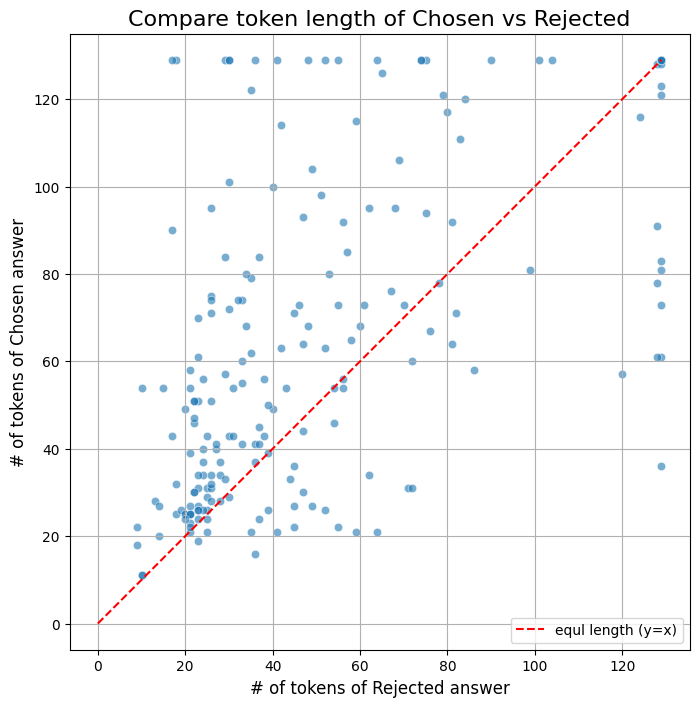

In [12]:
# 시각화 2: Chosen 길이 vs Rejected 길이 (Scatter Plot)
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df, x='rejected_len_tokens', y='chosen_len_tokens', alpha=0.6)
# y=x 기준선 추가 (두 길이가 같은 지점)
max_len = max(df['rejected_len_tokens'].max(), df['chosen_len_tokens'].max())
plt.plot([0, max_len], [0, max_len], color='red', linestyle='--', label='equl length (y=x)')
plt.title('Compare token length of Chosen vs Rejected', fontsize=16)
plt.xlabel('# of tokens of Rejected answer', fontsize=12)
plt.ylabel('# of tokens of Chosen answer', fontsize=12)
plt.legend()
plt.grid(True)
plt.axis('equal') # x, y축 스케일을 동일하게 설정
plt.show()

In [17]:
from scipy import stats

print("="*50)
print("     데이터셋 길이 편향 정량 분석 (수치 보고서)")
print("="*50)

# --- 1. 기본적인 통계 ---
avg_chosen_tokens = df['chosen_len_tokens'].mean()
avg_rejected_tokens = df['rejected_len_tokens'].mean()
avg_token_diff = df['token_diff'].mean()

print("\n[1. 평균 길이 분석]")
print(f"  - 평균 'Chosen' 토큰 길이  : {avg_chosen_tokens:.2f}")
print(f"  - 평균 'Rejected' 토큰 길이 : {avg_rejected_tokens:.2f}")
print(f"  ▶ 평균적인 길이 차이        : {avg_token_diff:.2f} 토큰 (Chosen이 더 김)")

print("\n" + "-"*40 + "\n")

# --- 2. 길이 우위 비율 ---
chosen_is_longer = (df['chosen_len_tokens'] > df['rejected_len_tokens']).sum()
total_pairs = len(df)
win_rate = chosen_is_longer / total_pairs

print("[2. 길이 우위 비율 분석]")
print(f"  - 전체 {total_pairs}개 쌍 중에서 'Chosen'의 길이가 더 긴 경우: {chosen_is_longer}개")
print(f"  ▶ 'Chosen' 길이 우위 비율   : {win_rate:.2%}")

print("\n" + "-"*40 + "\n")

# --- 3. 상대적 길이 비율 ---
# rejected_len_tokens가 0인 경우를 대비해 1로 바꿔서 계산 (division by zero 방지)
df['length_ratio'] = df['chosen_len_tokens'] / df['rejected_len_tokens'].replace(0, 1)
avg_ratio = df['length_ratio'].mean()

print("[3. 상대적 길이 비율 분석]")
print(f"  ▶ 'Chosen'은 'Rejected'보다 평균적으로 {avg_ratio:.2f}배 더 깁니다.")

print("\n" + "-"*40 + "\n")

# --- 4. 통계적 유의성 검정 (Paired t-test) ---
# t-statistic: 두 그룹의 평균 차이가 통계적으로 유의미한지를 나타내는 값
# p-value: 관찰된 차이가 우연히 발생했을 확률
t_stat, p_value = stats.ttest_rel(df['chosen_len_tokens'], df['rejected_len_tokens'])

print("[4. 통계적 유의성 검정 (Paired t-test)]")
print(f"  - T-statistic: {t_stat:.4f}")
print(f"  - P-value    : {p_value:e}") # 아주 작은 숫자는 지수 형태로 표시

if p_value < 0.05:
    print("  ▶ 결론: P-value가 0.05보다 매우 작으므로, 두 그룹 간의 길이 차이는")
    print("          '통계적으로 매우 유의미'합니다. 즉, 길이 편향이 명확하게 존재합니다.")
else:
    print("  ▶ 결론: P-value가 0.05보다 크므로, 관찰된 길이 차이는")
    print("          통계적으로 유의미하지 않을 수 있습니다 (우연일 가능성 존재).")
    
print("="*50)

     데이터셋 길이 편향 정량 분석 (수치 보고서)

[1. 평균 길이 분석]
  - 평균 'Chosen' 토큰 길이  : 63.27
  - 평균 'Rejected' 토큰 길이 : 48.34
  ▶ 평균적인 길이 차이        : 14.93 토큰 (Chosen이 더 김)

----------------------------------------

[2. 길이 우위 비율 분석]
  - 전체 196개 쌍 중에서 'Chosen'의 길이가 더 긴 경우: 140개
  ▶ 'Chosen' 길이 우위 비율   : 71.43%

----------------------------------------

[3. 상대적 길이 비율 분석]
  ▶ 'Chosen'은 'Rejected'보다 평균적으로 1.59배 더 깁니다.

----------------------------------------

[4. 통계적 유의성 검정 (Paired t-test)]
  - T-statistic: 6.2802
  - P-value    : 2.153864e-09
  ▶ 결론: P-value가 0.05보다 매우 작으므로, 두 그룹 간의 길이 차이는
          '통계적으로 매우 유의미'합니다. 즉, 길이 편향이 명확하게 존재합니다.


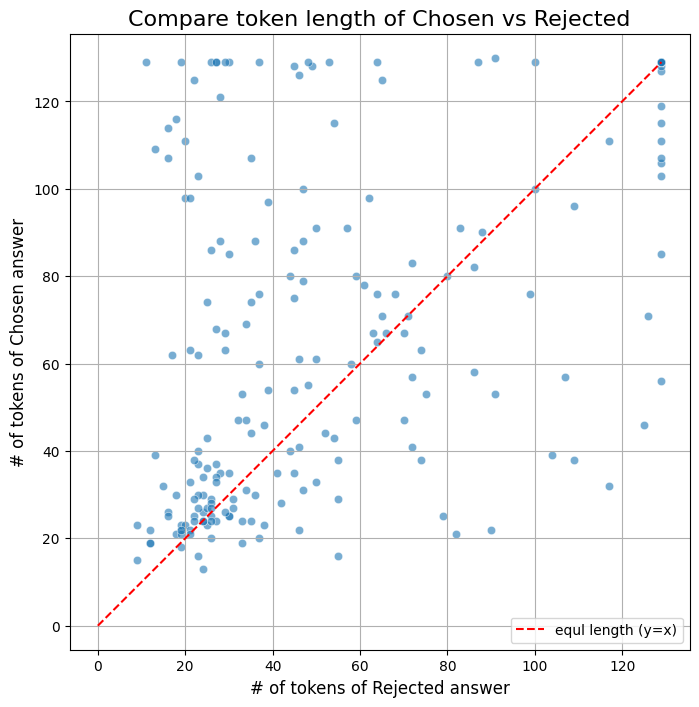

In [15]:
# 시각화 2: Chosen 길이 vs Rejected 길이 (Scatter Plot)
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df2, x='rejected_len_tokens', y='chosen_len_tokens', alpha=0.6)
# y=x 기준선 추가 (두 길이가 같은 지점)
max_len = max(df['rejected_len_tokens'].max(), df['chosen_len_tokens'].max())
plt.plot([0, max_len], [0, max_len], color='red', linestyle='--', label='equl length (y=x)')
plt.title('Compare token length of Chosen vs Rejected', fontsize=16)
plt.xlabel('# of tokens of Rejected answer', fontsize=12)
plt.ylabel('# of tokens of Chosen answer', fontsize=12)
plt.legend()
plt.grid(True)
plt.axis('equal') # x, y축 스케일을 동일하게 설정
plt.show()

In [18]:
from scipy import stats

print("="*50)
print("     데이터셋 길이 편향 정량 분석 (수치 보고서)")
print("="*50)

# --- 1. 기본적인 통계 ---
avg_chosen_tokens = df2['chosen_len_tokens'].mean()
avg_rejected_tokens = df2['rejected_len_tokens'].mean()
avg_token_diff = df2['token_diff'].mean()

print("\n[1. 평균 길이 분석]")
print(f"  - 평균 'Chosen' 토큰 길이  : {avg_chosen_tokens:.2f}")
print(f"  - 평균 'Rejected' 토큰 길이 : {avg_rejected_tokens:.2f}")
print(f"  ▶ 평균적인 길이 차이        : {avg_token_diff:.2f} 토큰 (Chosen이 더 김)")

print("\n" + "-"*40 + "\n")

# --- 2. 길이 우위 비율 ---
chosen_is_longer = (df2['chosen_len_tokens'] > df2['rejected_len_tokens']).sum()
total_pairs = len(df2)
win_rate = chosen_is_longer / total_pairs

print("[2. 길이 우위 비율 분석]")
print(f"  - 전체 {total_pairs}개 쌍 중에서 'Chosen'의 길이가 더 긴 경우: {chosen_is_longer}개")
print(f"  ▶ 'Chosen' 길이 우위 비율   : {win_rate:.2%}")

print("\n" + "-"*40 + "\n")

# --- 3. 상대적 길이 비율 ---
# rejected_len_tokens가 0인 경우를 대비해 1로 바꿔서 계산 (division by zero 방지)
df2['length_ratio'] = df2['chosen_len_tokens'] / df2['rejected_len_tokens'].replace(0, 1)
avg_ratio = df2['length_ratio'].mean()

print("[3. 상대적 길이 비율 분석]")
print(f"  ▶ 'Chosen'은 'Rejected'보다 평균적으로 {avg_ratio:.2f}배 더 깁니다.")

print("\n" + "-"*40 + "\n")

# --- 4. 통계적 유의성 검정 (Paired t-test) ---
# t-statistic: 두 그룹의 평균 차이가 통계적으로 유의미한지를 나타내는 값
# p-value: 관찰된 차이가 우연히 발생했을 확률
t_stat, p_value = stats.ttest_rel(df2['chosen_len_tokens'], df2['rejected_len_tokens'])

print("[4. 통계적 유의성 검정 (Paired t-test)]")
print(f"  - T-statistic: {t_stat:.4f}")
print(f"  - P-value    : {p_value:e}") # 아주 작은 숫자는 지수 형태로 표시

if p_value < 0.05:
    print("  ▶ 결론: P-value가 0.05보다 매우 작으므로, 두 그룹 간의 길이 차이는")
    print("          '통계적으로 매우 유의미'합니다. 즉, 길이 편향이 명확하게 존재합니다.")
else:
    print("  ▶ 결론: P-value가 0.05보다 크므로, 관찰된 길이 차이는")
    print("          통계적으로 유의미하지 않을 수 있습니다 (우연일 가능성 존재).")
    
print("="*50)

     데이터셋 길이 편향 정량 분석 (수치 보고서)

[1. 평균 길이 분석]
  - 평균 'Chosen' 토큰 길이  : 64.92
  - 평균 'Rejected' 토큰 길이 : 51.46
  ▶ 평균적인 길이 차이        : 13.46 토큰 (Chosen이 더 김)

----------------------------------------

[2. 길이 우위 비율 분석]
  - 전체 198개 쌍 중에서 'Chosen'의 길이가 더 긴 경우: 117개
  ▶ 'Chosen' 길이 우위 비율   : 59.09%

----------------------------------------

[3. 상대적 길이 비율 분석]
  ▶ 'Chosen'은 'Rejected'보다 평균적으로 1.69배 더 깁니다.

----------------------------------------

[4. 통계적 유의성 검정 (Paired t-test)]
  - T-statistic: 4.8568
  - P-value    : 2.426391e-06
  ▶ 결론: P-value가 0.05보다 매우 작으므로, 두 그룹 간의 길이 차이는
          '통계적으로 매우 유의미'합니다. 즉, 길이 편향이 명확하게 존재합니다.
